In [1]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/')
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/.ipynb_checkpoints')
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
sys.path.append('/home/massoale/Bureau/Stage_M2/stage_diagsdiagnostics_pkg/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import io_utils as io
import operators as op
import qgutils as qg
import xarray as xr
import scipy as sp

## Charging the parameters of the simulation

In [2]:
#Number of simulation
n=53

#choose between 'local' or 'dahu'
where='dahu'


#Reading the netcdf file


if where=='local':
    if n<10:
        simu_name='outdir_000'+str(n)
    elif n<100 and n>=10:
        simu_name='outdir_00'+str(n)
    Path='/home/massoale/Simu_Test/qgw-main/src/'+simu_name+'/'

elif where=='dahu':
    simu_name='dahu_'+str(n)
    Path='/home/massoale/Simu_Test/simu_dahu/simu_dahu'+str(n)+'/outdir_0001/'
    
else:
    print('Error: where not recognized')
    sys.exit()
print('la simulation chargée est: ' + simu_name )
print("depuis: "+where)

filenames=['/vars.nc']



dataset=nc.Dataset(Path+filenames[0])
print(dataset.variables.keys())

t=dataset.variables['time'][:]
x=dataset.variables['x'][:]
y=dataset.variables['y'][:]
psi=dataset.variables['psi'][:,:,:,:]
q=dataset.variables['q'][:,:,:,:]
print("psi shape",psi.shape)


la simulation chargée est: dahu_53
depuis: dahu
dict_keys(['time', 'y', 'x', 'level', 'psi', 'q'])
psi shape (140, 1, 512, 512)


In [3]:
ds = xr.open_dataset(Path+filenames[0])
ds

<xarray.Dataset> Size: 294MB
Dimensions:  (time: 140, y: 512, x: 512, level: 1)
Coordinates:
  * time     (time) float32 560B 0.0 10.0 20.0 ... 1.37e+03 1.38e+03 1.39e+03
  * y        (y) float32 2kB 0.0 0.01227 0.02454 0.03682 ... 6.246 6.259 6.271
  * x        (x) float32 2kB 0.0 0.01227 0.02454 0.03682 ... 6.246 6.259 6.271
  * level    (level) float32 4B 0.0
Data variables:
    psi      (time, level, y, x) float32 147MB ...
    q        (time, level, y, x) float32 147MB ...

In [4]:
#Lecture des paramètres :

param=io.read_params(Path)
print(param)
f0= param['f0']
beta=param['beta']
hEkb=param['hEkb']
dh=param['dh'][0]
Lx=param['Lx']
nx=param['NX']
ny=param['NY']
k_f=param['k_f']
sigma_f=param['sigma_f']
bc_fac=param['bc_fac']
nu_hyper=param['nu_hyper']
n_hyper=param['n_hyper']
dt_out=param['dt_out']


print("we get one output every ",dt_out,"s")

{'NX': 512.0, 'NY': 512.0, 'nl': 1.0, 'Lx': 6.283185307179586, 'f0': 2.0, 'beta': 10.0, 'k_f': 32.0, 'sigma_f': 0.002, 'bc_fac': -1.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 9e-15, 'n_hyper': 6.0, 'hEkb': 0.0007, 'tend': 1576800000000.0, 'dt_out': 10.0}
we get one output every  10.0 s


In [5]:
print(np.pi*2)

6.283185307179586


In [6]:
#computing u and v from psi
delta=Lx/nx
u,v=op.calc_uv(psi[-100:,0,:,:],delta,bc_fac)
energy=0.5*(u**2+v**2)


# Looking at the energy at the end of the simu

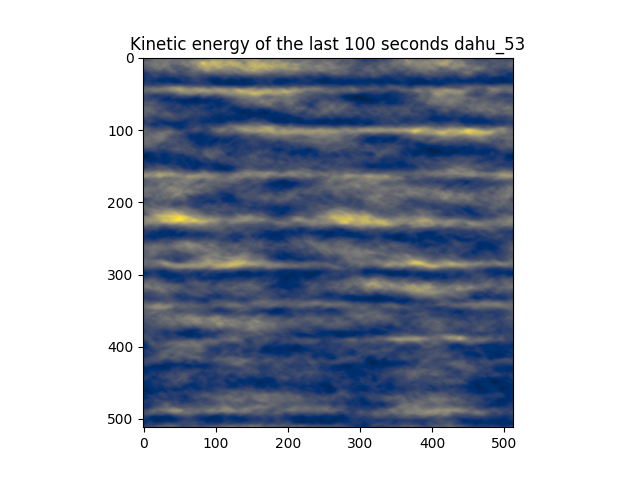

In [7]:
time_start=10

plt.figure()
plt.imshow(np.mean(energy[-time_start:,:,:],axis=0),cmap='cividis')
plt.title('Kinetic energy of the last '+str(time_start)+ '0 seconds '+simu_name)
plt.savefig('figures/KE_picture_'+simu_name+'.png')
plt.show()

## Making a fourier transform of the psi data

/tmp/ipykernel_120117/3470971103.py:40: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(energy_spectrum ), extent=(-np.max(kx), np.max(kx), -np.max(ky), np.max(ky)), cmap='hot', origin='lower',vmin=0,vmax=10)


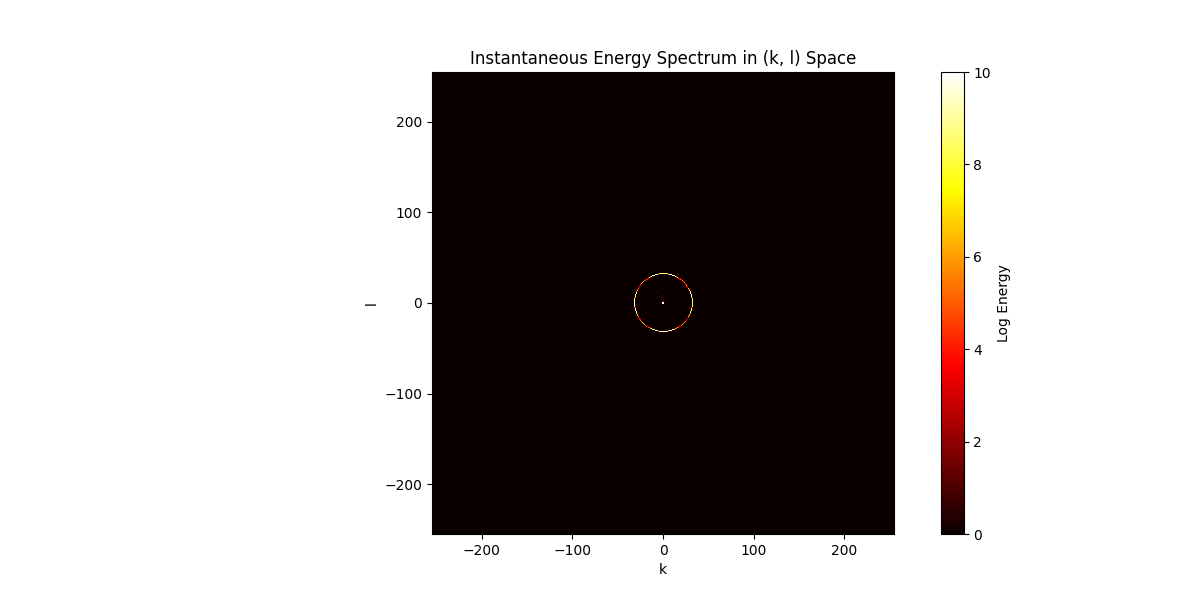

In [8]:

#Making a fourier series of the data:


#Selecting the indice corresponding to the time
time_sel=1
psi_data=psi[time_sel,0,:,:]


# 2D Fourier Transform
fft_result = np.fft.fft2(psi_data)
fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center
n = psi_data.shape[0]
dx=Lx/nx/(2*np.pi)
dy=Lx/ny/(2*np.pi)

kx=np.fft.fftfreq(int(nx),d=dx)
ky=np.fft.fftfreq(int(ny),d=dy)
kx_reshaped=np.zeros_like(kx)
kx_reshaped[0:len(kx)//2]=kx[len(kx)//2:]
kx_reshaped[len(kx)//2:]=kx[0:len(kx)//2]

ky_reshaped=np.zeros_like(ky)
ky_reshaped[0:len(ky)//2]=ky[len(ky)//2:]
ky_reshaped[len(ky)//2:]=ky[0:len(ky)//2]

Kx,Ky=np.meshgrid(kx_reshaped,ky_reshaped)
Ky=np.flipud(Ky)
k_norm=np.sqrt(Kx**2+Ky**2)

# 2D Fourier Transform
fft_result = np.fft.fft2(psi_data[:,:])
fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center
epsilon = 1e-10  # Small value to avoid log(0)

#Calculating Energy

energy_spectrum = np.abs(fft_shifted) ** 2 * k_norm**2
# Step 3: Plot the Spectrum
plt.figure(figsize=(12, 6))
plt.imshow(np.log(energy_spectrum ), extent=(-np.max(kx), np.max(kx), -np.max(ky), np.max(ky)), cmap='hot', origin='lower',vmin=0,vmax=10)


plt.colorbar(label='Log Energy')
plt.xlabel('k')
plt.ylabel('l')
plt.title('Instantaneous Energy Spectrum in (k, l) Space')
plt.show()


" Considering the averaged energy spectrum over a few snapshots

/home/massoale/.local/lib/python3.10/site-packages/numpy/ma/core.py:5334: RuntimeWarning: Mean of empty slice.
  result = super().mean(axis=axis, dtype=dtype, **kwargs)[()]
/home/massoale/.local/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


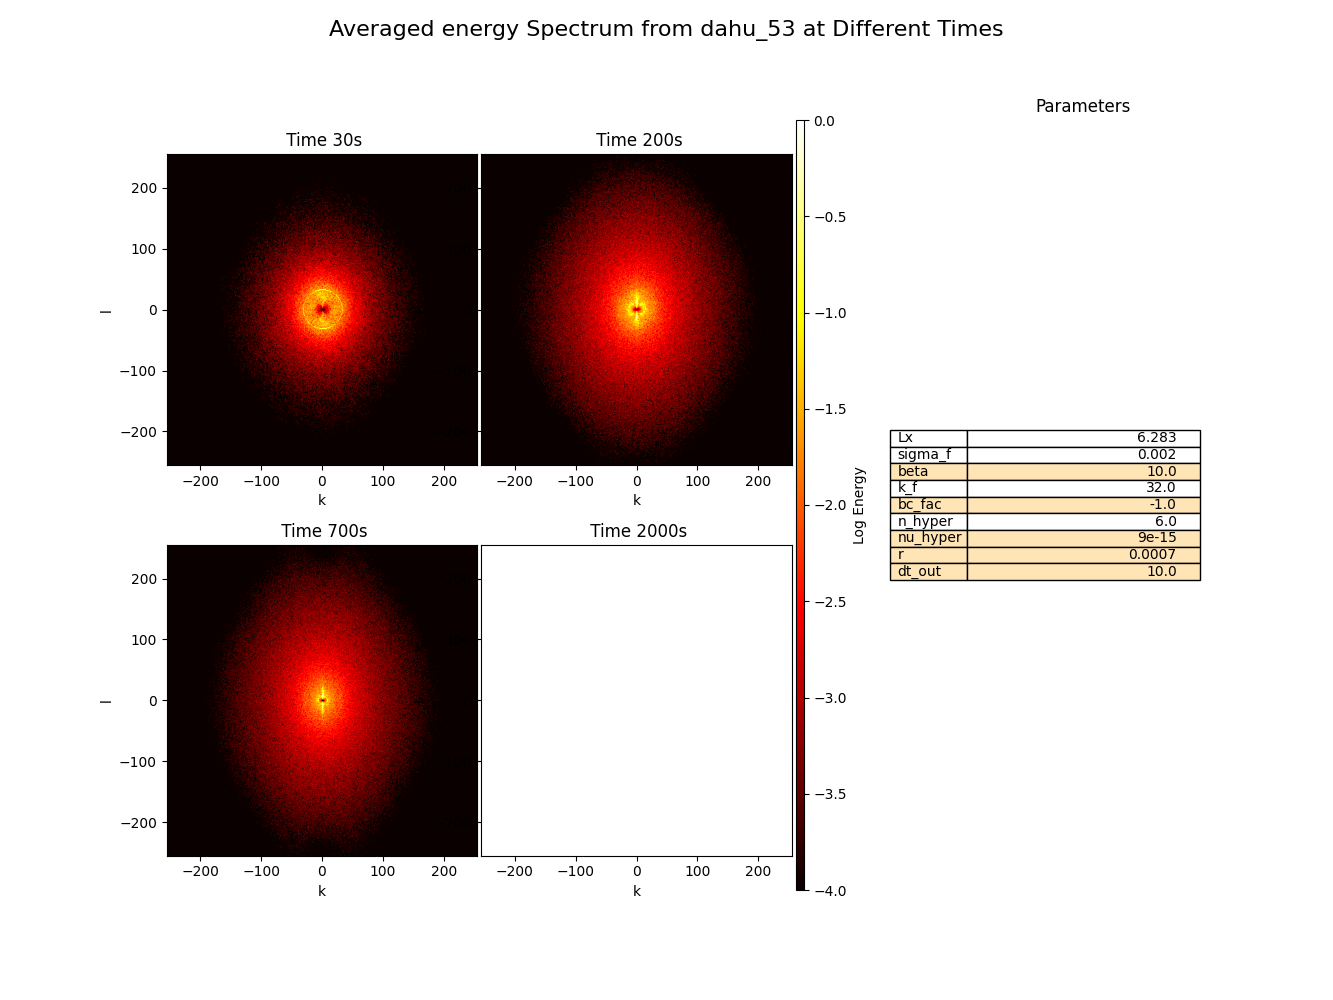

In [9]:

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the times to visualize
times_to_plot = [3, 20,70,200]

# Convertir Lx en float avec 3 décimales
Lx_formatted = "{:.3f}".format(Lx)

ratio=5/6
# Création de la figure
fig = plt.figure(figsize=(16*ratio, 12*ratio))

# Grid spec pour diviser la figure en sections
grid = fig.add_gridspec(nrows=2, ncols=5, width_ratios=[4,4,0.1,2,3],hspace=0.03,wspace=0.02)


dx=Lx/nx/(2*np.pi)
dy=Lx/ny/(2*np.pi)

kx=np.fft.fftfreq(int(nx),d=dx)
ky=np.fft.fftfreq(int(ny),d=dy)
kx_reshaped=np.zeros_like(kx)
kx_reshaped[0:len(kx)//2]=kx[len(kx)//2:]
kx_reshaped[len(kx)//2:]=kx[0:len(kx)//2]

ky_reshaped=np.zeros_like(ky)
ky_reshaped[0:len(ky)//2]=ky[len(ky)//2:]
ky_reshaped[len(ky)//2:]=ky[0:len(ky)//2]

Kx,Ky=np.meshgrid(kx_reshaped,ky_reshaped)
Ky=np.flipud(Ky)
k_norm=np.sqrt(Kx**2+Ky**2)



# Loop through each time and plot the corresponding image
for idx, time_sel in enumerate(times_to_plot):
    # Average psi over 5 time steps
    psi_avg = np.mean(psi[time_sel:time_sel+5], axis=0)
    
    # 2D Fourier Transform
    fft_result = np.fft.fft2(psi_avg[0,:,:])
    fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center
    epsilon = 1e-10  # Small value to avoid log(0)
    #Calculating Energy
    energy_spectrum = np.abs(fft_shifted) ** 2 * k_norm**2
    #Plotting the Spectrum
    ax = fig.add_subplot(grid[idx // 2, idx % 2])
    img=ax.imshow(np.log(energy_spectrum+epsilon), extent=(-np.max(kx), np.max(kx), -np.max(ky), np.max(ky)), cmap='hot', origin='lower',vmin=-4)
    ax.set_xlabel('k')
    ax.set_ylabel('l')
    ax.set_title(f' Time {time_sel*10}'+ 's')


ax2=fig.add_subplot(grid[:, 2])

cbar = plt.colorbar(img, cax=ax2)
cbar.set_label('Log Energy')


# Tableau des paramètres sur la droite
param_table = fig.add_subplot(grid[:, 4])
param_table.axis('off')  # Pour enlever les axes

r=f0*hEkb/(dh*2)
colors2D = [['white'] for _ in range(2)] + [['moccasin']] + [['white']] + [['moccasin']] + [['white']] + [['moccasin'] for _ in range(3)]
colors = ['white' for _ in range(2) ] + ['moccasin'] + ['white'] + ['moccasin'] + ['white'] + ['moccasin' for _ in range(3) ]

param_table.table(cellText=[[Lx_formatted], [sigma_f],[beta] , [k_f], [bc_fac], [n_hyper], [nu_hyper], [r] ,[dt_out]],
                  rowLabels=['Lx','sigma_f','beta', 'k_f', 'bc_fac', 'n_hyper', 'nu_hyper', 'r', 'dt_out'],
                  loc='center' ,cellColours=colors2D,rowColours=colors)
param_table.set_title('Parameters')

plt.subplots_adjust(wspace=0.5)  # Adjust horizontal spacing
plt.suptitle('Averaged energy Spectrum from '+str(simu_name)+' at Different Times', fontsize=16)
#plt.tight_layout()
plt.savefig('./figures/Energy_Spectrum_'+str(simu_name)+'.png')
plt.show()


As time increases, the energy goes toward smaller wavenumbers and thus greater scales. There are more energy distributed along the y axis arround the k=0 emphasizing the presence of jets. 

/tmp/ipykernel_120117/571191728.py:9: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(energy_spectrum) , extent=(-np.pi, np.pi, -np.pi, np.pi), cmap='Greys', origin='lower')


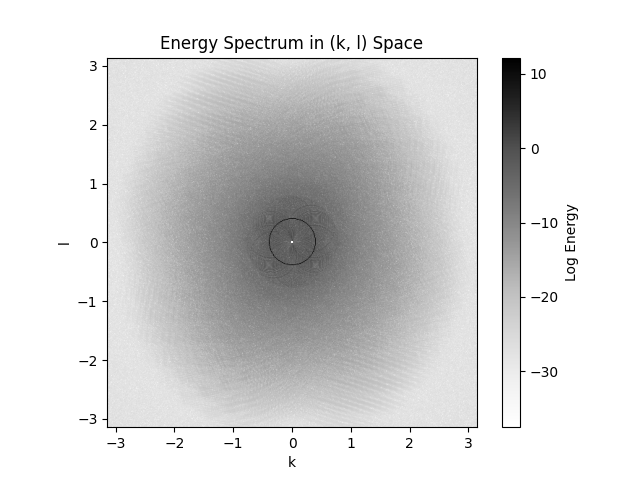

In [10]:
# Assuming ii[10,0,:,:]

fft_result = np.fft.fft2(psi_data)# Step 1: Fourier Transform
fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center

energy_spectrum = np.abs(fft_shifted) ** 2* k_norm**2

plt.figure()
plt.imshow(np.log(energy_spectrum) , extent=(-np.pi, np.pi, -np.pi, np.pi), cmap='Greys', origin='lower')


plt.colorbar(label='Log Energy')
plt.xlabel('k')
plt.ylabel('l')
plt.title('Energy Spectrum in (k, l) Space')
plt.show()



# Energy\Enstrophy checking
Using Lennard python tools to check things with the simu data

In [11]:
from diagnostics_pkg import operators as op


(139, 512, 512)
Energy dissipated by drag + Energy dissipated by viscosity-Enerjy injected = -5e-07
Energy_diss_drag/Energy_injected 80.79 %


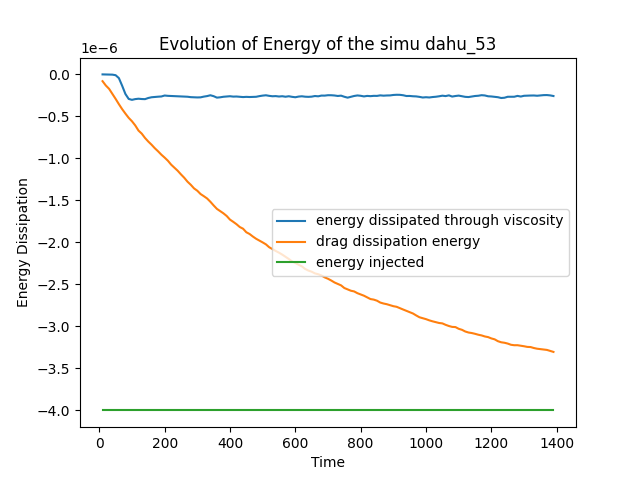

In [12]:

psi_data = psi[1:, 0, :, :]
q_data = q[1:, 0, :, :]

dx=x[-1]/x.shape[0]
dy=y[-1]/y.shape[0]
Lx=x[-1] #Lengh of the domain
Ly=y[-1] #Width of the domain

#Calculating the energy
energy_totale=op.calc_en(psi_data, q_data,dx,bc_fac=bc_fac)/Lx**2


enstro=op.calc_lap(psi_data,dx,bc_fac=bc_fac)**2/2
print(np.shape(enstro))
enstro_mean=np.mean(enstro,axis=(1,2))
#Calculating the total enstrophy for each snapshots
enstro_tot=np.sum(enstro,axis=(1,2))


dx=x[-1]/x.shape[0]
r=f0*hEkb/(dh*2)


#energy injectée :
energy_inj=np.zeros_like(energy_totale)
energy_inj[:]=sigma_f**2
energy_diss=-2*energy_totale*r
#enstro_diss=-2*nu_hyper*enstro_mean

#Calculating the enerrgy dissipated by hyper-viscosity
lap_vorticity=op.calc_lap(q_data,dx,bc_fac=bc_fac)
#palenstro_tot=np.sum(lap_vorticity**2,axis=(1,2))/Lx**2
palenstro_tot=np.mean(lap_vorticity**2,axis=(1,2))
enstro_diss=-nu_hyper*palenstro_tot 

mean_enstro_diss=np.mean(enstro_diss[-20:])
mean_energy_diss=np.mean(energy_diss[-20:])
mean_energy_inj=np.mean(energy_inj[-20:])
print("Energy dissipated by drag + Energy dissipated by viscosity-Enerjy injected =",round(-mean_energy_diss-mean_enstro_diss-mean_energy_inj,7))


ratioE=mean_energy_diss/mean_energy_inj*100
print("Energy_diss_drag/Energy_injected",-round(ratioE,3),'%')

plt.figure()

plt.plot(t[1:],enstro_diss,label='energy dissipated through viscosity')
plt.plot(t[1:],energy_diss,label='drag dissipation energy')
plt.plot(t[1:],-energy_inj,label='energy injected')

plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy Dissipation')
plt.title('Evolution of Energy of the simu '+str(simu_name))
#plt.savefig('./figures/Energy_Dissipation_'+str(simu_name)+'.png')
plt.show()




# Energy cascade

/tmp/ipykernel_120117/1104951696.py:36: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(psd),extent=(np.min(kx), np.max(kx), np.min(ky), np.max(ky)), cmap='hot', origin='lower',vmin=4,vmax=10)


chargement de la frame 130
chargement de la frame 131
chargement de la frame 132
chargement de la frame 133
chargement de la frame 134


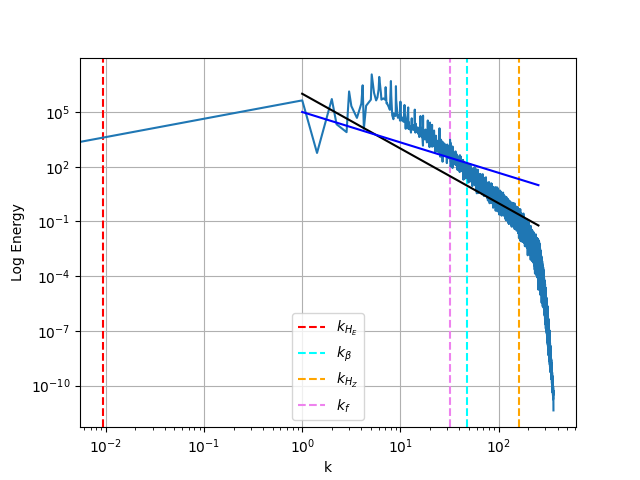

Text(0.5, 0.2, 'Parameters')

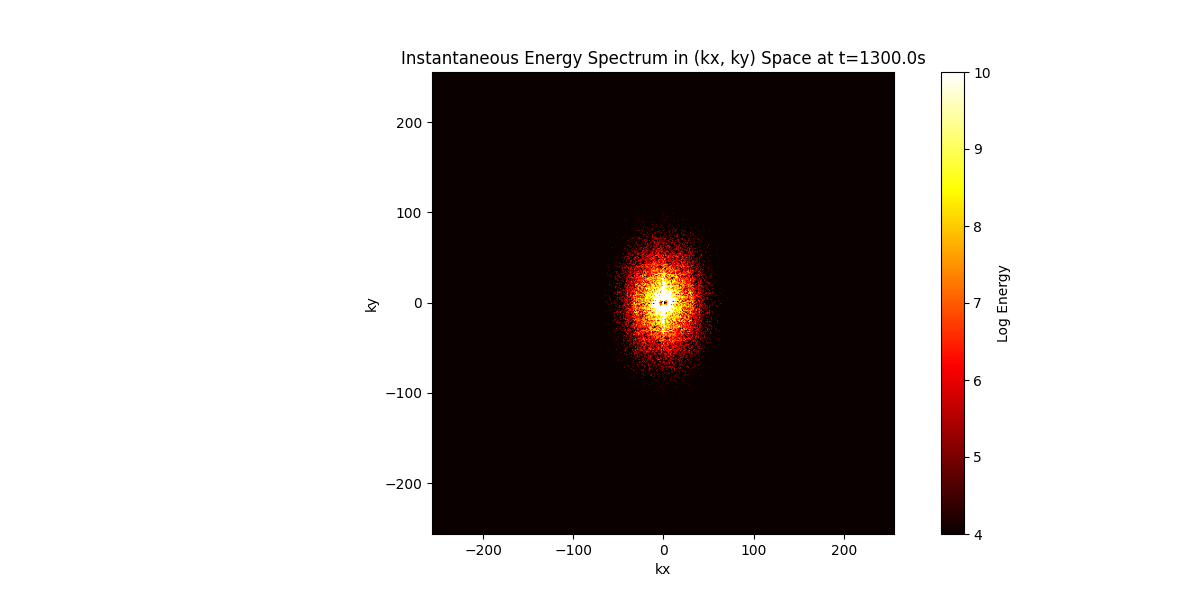

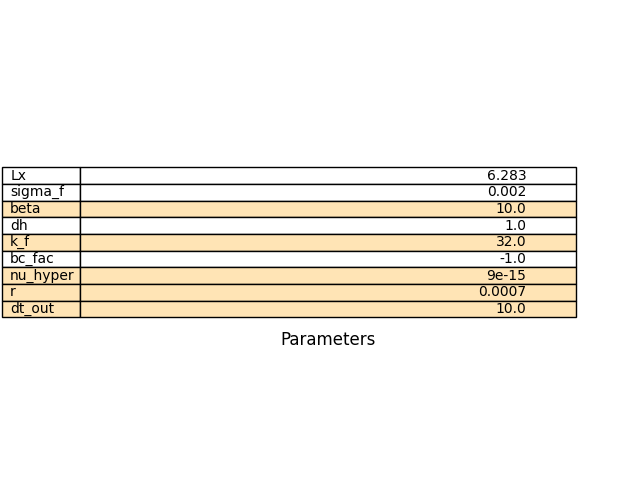

In [13]:


# Selecting the index corresponding to the time you want to visualize
time_sel = len(t)-10
averaging_over = 5  # Number of time steps to average over

k = np.arange(1.,nx//2)
epsilon=sigma_f**2
eta=k_f**2*epsilon

#Calculating the wavenumbers:
dx=Lx/nx/(2*np.pi)
dy=Ly/ny/(2*np.pi)

kx=np.fft.fftfreq(int(nx),d=dx)
ky=np.fft.fftfreq(int(ny),d=dy)
kx_reshaped=np.zeros_like(kx)
kx_reshaped[0:len(kx)//2]=kx[len(kx)//2:]
kx_reshaped[len(kx)//2:]=kx[0:len(kx)//2]

ky_reshaped=np.zeros_like(ky)
ky_reshaped[0:len(ky)//2]=ky[len(ky)//2:]
ky_reshaped[len(ky)//2:]=ky[0:len(ky)//2]

Kx,Ky=np.meshgrid(kx_reshaped,ky_reshaped)
Ky=np.flipud(Ky)
k_norm=np.sqrt(Kx**2+Ky**2)


# Get the power spectrum density
psi_fft = np.fft.fft2(psi[time_sel, 0, :, :])
psi_fft_shifted = np.fft.fftshift(psi_fft)
psd = np.abs(psi_fft_shifted)**2*k_norm**2


# Plot the 1D power spectrum density
plt.figure(figsize=(12, 6))
plt.imshow(np.log(psd),extent=(np.min(kx), np.max(kx), np.min(ky), np.max(ky)), cmap='hot', origin='lower',vmin=4,vmax=10)
plt.colorbar(label='Log Energy')
plt.xlabel('kx')
plt.ylabel('ky')
plt.title('Instantaneous Energy Spectrum in (kx, ky) Space at t='+str(t[time_sel])+'s')

psd_1d_avg=np.zeros_like(np.unique(k_norm))
i=0
for time in range(time_sel,time_sel+averaging_over):
    print("chargement de la frame",time)
    psi_data = psi[time, 0, :, :]


    psi_fft = np.fft.fft2(psi_data)
    psi_fft_shifted = np.fft.fftshift(psi_fft)
    psd = np.abs(psi_fft_shifted)**2#*k_norm**2
    psd_1d=np.zeros_like(np.unique(k_norm))
    k_values=np.sort(np.unique(k_norm))
   
                
    #Calculating 1d spectrum
    for idx, kx_v in enumerate(kx_reshaped):
        for idy, ky_v in enumerate(ky_reshaped):
            k_norm_v=np.sqrt(kx_v**2+ky_v**2)#Recalculating the norm of the wavenumber
            indice=np.where(k_values==k_norm_v)
            psd_1d[indice]+=psd[idx,idy]*k_norm_v
    psd_1d_avg+=psd_1d
    i+=1
psd_1d_avg=psd_1d_avg/(i)



#plotting the 1d spectrum

plt.figure()
r=f0*hEkb/(2*dh)
k_beta=(beta**3/epsilon)**(1/5)
kH_E=np.sqrt(r**3/epsilon)
kh_Z=(eta**(1/3)/(nu_hyper))**(1/n_hyper)
plt.axvline(x=kH_E, color='red', linestyle='--', label='$k_{H_E}$')
plt.axvline(x=k_beta, color='cyan', linestyle='--', label='$k_\\beta$')
plt.axvline(x=kh_Z, color='orange', linestyle='--', label='$k_{H_Z}$')
plt.axvline(x=k_f, color='violet', linestyle='--', label='$k_{f}$')
plt.loglog(k_values,psd_1d_avg)
plt.plot(k, 1e6 * k**(-3), color='k')
plt.plot(k, 1e5 * k**(-5/3), color='b')
plt.grid()

plt.xlabel('k')
plt.ylabel('Log Energy')
plt.legend()
plt.show()

#Adding a table with the parameters
fig=plt.figure()

# Tableau des paramètres sur la droite
param_table = fig.add_subplot(1,1,1)
param_table.axis('off')  # Pour enlever les axes

r=f0*hEkb/(dh*2)
colors2D = [['white'] for _ in range(2)] + [['moccasin']] + [['white']] + [['moccasin']] + [['white']] + [['moccasin'] for _ in range(3)]
colors = ['white' for _ in range(2) ] + ['moccasin'] + ['white'] + ['moccasin'] + ['white'] + ['moccasin' for _ in range(3) ]

param_table.table(cellText=[[Lx_formatted], [sigma_f],[beta], [dh] , [k_f], [bc_fac], [nu_hyper], [r] ,[dt_out]],
                  rowLabels=['Lx','sigma_f','beta', 'dh', 'k_f', 'bc_fac', 'nu_hyper', 'r', 'dt_out'],
                  loc='center' ,cellColours=colors2D,rowColours=colors)
param_table.set_title('Parameters',y=0.2)



## Energy Spectrum with Bruno code

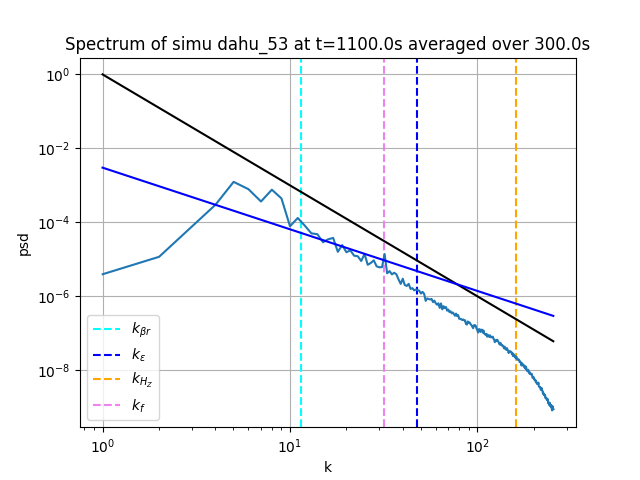

In [14]:
#Plotting the 1D spec using Bruno's code
time_sel=-30
averaging_over=30

psi_data = psi[time_sel, 0, :, :]
q_data = q[time_sel, 0, :, :]
kr, spec1d=qg.fftlib.get_spec_1D(psi_data, q_data, dx,window=None, all_kr= False, averaging='radial')

spec1d_avg=np.zeros_like(spec1d)
for time in range(time_sel,time_sel+averaging_over):
    psi_data = psi[time, 0, :, :]
    q_data = q[time, 0, :, :]
    kr, spec1d=qg.fftlib.get_spec_1D(psi_data, q_data, dx,window=None, all_kr= False, averaging='radial')
    spec1d_avg+=spec1d

spec1d_avg=spec1d_avg/averaging_over

r=f0*hEkb/(2*dh)

kH_E=np.sqrt(r**3/epsilon)
kh_Z=(eta**(1/3)/(nu_hyper))**(1/n_hyper)
k_betar=beta**0.5/(epsilon/r)**(1/4)
k_epsilon=(beta**3/epsilon)**(1/5)
plt.figure()

#plt.axvline(x=kH_E, color='red', linestyle='--', label='$k_{H_E}$')
plt.axvline(x=k_betar, color='cyan', linestyle='--', label='$k_{\\beta r}$')
plt.axvline(x=k_epsilon, color='blue', linestyle='--', label='$k_{\\epsilon}$')
plt.axvline(x=kh_Z, color='orange', linestyle='--', label='$k_{H_Z}$')
plt.axvline(x=k_f, color='violet', linestyle='--', label='$k_{f}$')


plt.loglog(kr,np.abs(spec1d))
k = np.arange(1.,nx//2)
plt.plot(k, 1 * k**(-3), color='k')
plt.plot(k, 3e-3 * k**(-5/3), color='b')
plt.title('Spectrum of simu '+ str(simu_name)+' at t='+str(t[time_sel])+'s averaged over '+ str(averaging_over*dt_out)+'s')
plt.xlabel('k')
plt.ylabel('psd')
plt.legend()

plt.grid()

In [15]:

# psi_data = psi[:, 0, :, :]


# def spec2d(nx, kk, phi, alpha=0):
#     hphi = np.abs(np.fft.fft2(phi))**2

#     if alpha>0:
#         hphi *= kk**alpha
#     spec = np.zeros((nx//2,))
#     for i in range(nx//2):
#         spec[i] = np.sum(hphi[(kk>=i) & (kk<(i+1))])
#     return spec

# def set_x_and_k(n, L):
#     k = ((n//2+np.arange(n)) % n) - n//2
#     return (np.arange(n)+0.5)*L/n, 2*np.pi*k/L

# ny, nx = np.shape(psi_data[0])

# _, kx = set_x_and_k(nx, 2*np.pi)
# _, ky = set_x_and_k(ny, 2*np.pi)
# kkx, kky = np.meshgrid(kx, ky)
# kk = np.sqrt(kkx**2 + kky**2)




# # let's plot the Kinetic Energy spectrum
# # in Fourier space KE = k^2 |psi|^2 * 0.5

# plt.figure(figsize=(12,8))

# for k, time in enumerate(t[1::20]):
    
#     h = spec2d(nx, kk, psi_data[k], alpha=2)
#     plt.loglog(h, label='t=%.0f' % time)
# #plt.axis([0.1, 100, 1e-3, 1e5])
# plt.grid()
# k = np.arange(1.,nx//2)
# plt.plot(k, 5e8 * k**(-3), color='k')
# #plt.plot(k, 5e16 * k**(-8), color='r')
# plt.plot(k, 1e-4 * k**(-5./3), color='b') # the coefficient set the vertical position of the line
# plt.text(1.5, 0.01, r'$k^{-5/3}$', fontsize=16)
# plt.text(70,0.001, r'$k^{-3}$', fontsize=16)
# plt.legend()
# plt.xlabel('k')
# plt.ylabel('P.S.D.')
# plt.title('Kinetic Energy Spectrum of the simulation '+str(simu_name))

In [16]:
# # 
# from scipy import fftpack
# # for 2d spectra
# time_sel=-1

# def azimuthalAverage(image, center=None, stddev=False, returnradii=False, return_nr=False,
#         binsize=1, weights=None, steps=False, interpnan=False, left=None, right=None):
#     """
#     Calculate the azimuthally averaged radial profile.

#     image - The 2D image
#     center - The [x,y] pixel coordinates used as the center. The default is
#              None, which then uses the center of the image (including
#              fractional pixels).
#     stddev - if specified, return the azimuthal standard deviation instead of the average
#     returnradii - if specified, return (radii_array,radial_profile)
#     return_nr   - if specified, return number of pixels per radius *and* radius
#     binsize - size of the averaging bin.  Can lead to strange results if
#         non-binsize factors are used to specify the center and the binsize is
#         too large
#     weights - can do a weighted average instead of a simple average if this keyword parameter
#         is set.  weights.shape must = image.shape.  weighted stddev is undefined, so don't
#         set weights and stddev.
#     steps - if specified, will return a double-length bin array and radial
#         profile so you can plot a step-form radial profile (which more accurately
#         represents what's going on)
#     interpnan - Interpolate over NAN values, i.e. bins where there is no data?
#         left,right - passed to interpnan; they set the extrapolated values

#     If a bin contains NO DATA, it will have a NAN value because of the
#     divide-by-sum-of-weights component.  I think this is a useful way to denote
#     lack of data, but users let me know if an alternative is prefered...
   
#     """
#     # Calculate the indices from the image
#     y, x = np.indices(image.shape)
#     if center is None:
#         center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
#     r = np.hypot(x - center[0], y - center[1])
#     if weights is None:
#         weights = np.ones(image.shape)
#     elif stddev:
#         raise ValueError("Weighted standard deviation is not defined.")
#     # the 'bins' as initially defined are lower/upper bounds for each bin
#     # so that values will be in [lower,upper)  
#     nbins = int((np.round(r.max() / binsize)+1))
#     maxbin = nbins * binsize
#     bins = np.linspace(0,maxbin,nbins+1)
#     # but we're probably more interested in the bin centers than their left or right sides...
#     bin_centers = (bins[1:]+bins[:-1])/2.0
#     # Find out which radial bin each point in the map belongs to
#     whichbin = np.digitize(r.flat,bins)
#     # how many per bin (i.e., histogram)?
#     # there are never any in bin 0, because the lowest index returned by digitize is 1
#     nr = np.bincount(whichbin)[1:]
#     # recall that bins are from 1 to nbins (which is expressed in array terms by arange(nbins)+1 or xrange(1,nbins+1) )
#     # radial_prof.shape = bin_centers.shape
#     if stddev:
#         radial_prof = np.array([image.flat[whichbin==b].std() for b in range(1,nbins+1)])
#     else:
#         # add renormalization (2pi/k/n)
#         #norm = np.array([weights.flat[whichbin==b].sum() for b in xrange(1,np.int(nbins)+1)])  
#         #norm_k = np.array([2*np.pi*(b) for b in xrange(1,np.int(nbins)+1)])       
#         radial_prof = np.array([(image*weights).flat[whichbin==b].sum() / weights.flat[whichbin==b].sum() * 2*np.pi*b for b in range(1,int(nbins)+1)])  
#         #or not
#         #radial_prof = np.array([(image*weights).flat[whichbin==b].sum() for b in xrange(1,np.int(nbins)+1)])        
#     #import pdb; pdb.set_trace()
#     if interpnan:
#         radial_prof = np.interp(bin_centers,bin_centers[radial_prof==radial_prof],radial_prof[radial_prof==radial_prof],left=left,right=right)
#     if steps:
#         xarr = np.array(zip(bins[:-1],bins[1:])).ravel()
#         yarr = np.array(zip(radial_prof,radial_prof)).ravel()
#         return xarr,yarr
#     elif returnradii:
#         return bin_centers,radial_prof
#     elif return_nr:
#         return nr,bin_centers,radial_prof
#     else:
#         return radial_prof



# def myfft_2d(myvar,dx=1):
#     han = np.sqrt(np.outer(np.hanning(myvar.shape[0]),np.hanning(myvar.shape[1])))
#     F1 = fftpack.fft2(myvar*han)  
#     psd2D = fftpack.fftshift(np.abs(F1*np.conj(F1)))/(myvar.shape[0]*myvar.shape[1])
#     fftemp = azimuthalAverage(psd2D)[:myvar.shape[0]//2+myvar.shape[0]%2]
#     ####
#     nx1 = int(myvar.shape[0]); 
#     f = np.arange(nx1/2)/(dx*nx1)*1#1000./(2*np.pi)# in cpkm
#     df = f[2] - f[1]
#     fftemp /= df
#     return f,fftemp


# ########################

# def plot_psd2d(var,dx,k_beta,kH_E,k_f,krh):

#     # compute and plot PSD(u) for t=0
#     f, P = myfft_2d(var[1,:,:],dx=dx)
#     plot0, = plt.loglog(f, P,linewidth=5.)
    
#     # compute and plot PSD(u) for t>0
#     for it in range(0,len(t),20):
#         f, P =myfft_2d(var[it,:,:],dx=dx)
#         plt.loglog(f, P,linewidth=.5)
    
#     plot1, = plt.loglog(f, P,'--',linewidth=5)
    
#     plot3, = plt.loglog(f, f**(-5/3)*P[1]/f[1]**(-5/3)*10**1,'--',color='b',linewidth=2)
#     plot2, = plt.loglog(f, f**(-3)*P[1]/f[1]**(-3)*10**5,'-',color='k',linewidth=2)

#     plt.grid( which='both', color='0.65',linestyle='-',linewidth=0.2)
#     plt.axvline(x=krh, color='blue', linestyle='--', label='$k_{rh}$')
#     plt.axvline(x=k_f, color='green', linestyle='--', label='$k_f$')
#     plt.axvline(x=kH_E, color='red', linestyle='--', label='$k_{H_E}$')
#     plt.axvline(x=k_beta, color='cyan', linestyle='--', label='$k_\\beta$')
#     plt.axvline(x=kh_Z, color='orange', linestyle='--', label='$k_{H_Z}$')
#     plt.legend([plot0,plot1,plot2,plot3], ['initial','final',r'$k^{-3}$',                        
#                                     r'$k^{-5/3}$'],
#                                     bbox_to_anchor=(0.95, 0.95),loc=0, borderaxespad=0.)
#     ax1.set_xlabel('k [cpkm]'); 
#     ax1.set_ylabel('KE density [m$^2$ s$^{-2}$/cpkm]'); 

#     ########################

# # plot PSD
# fig=plt.figure(figsize=(6.,6.))
# ax1 = fig.add_subplot(111,facecolor='Gainsboro')   
# var = psi[:,0,:,:]
# dx=Lx/nx/(2*np.pi)


# r=f0*hEkb/(2*dh)
# k_beta=(beta**3/epsilon)**(1/5)
# kH_E=np.sqrt(r**3/epsilon)
# u,v=op.calc_uv(psi_data[-50:-1,:,:],dx,bc_fac)
# U=np.sqrt(u**2+v**2)

# Rh=np.sqrt(np.mean(U[-50:-1,:,:])/beta)
# krh=1/Rh


# plot_psd2d(var,dx,k_beta,kH_E,k_f,krh)

# plt.legend()
# plt.title('KE density, 2D')
# plt.savefig('./figures/KE_density_2D_'+str(simu_name)+'.png')
# plt.show()

In [17]:
#Isolating the most energetic wavenumbers
# Get the power spectrum density
time_sel = 1#len(t)-1
psi_fft = np.fft.fft2(psi[time_sel, 0, :, :])
psi_fft_shifted = np.fft.fftshift(psi_fft)
psd = np.abs(psi_fft_shifted)**2*k_norm**2
epsilon = 1e-10  # Small value to avoid log(0)

indice_max_psd=np.where(psd==np.max(psd))
print(indice_max_psd)

print(Kx[indice_max_psd],Ky[indice_max_psd])

(array([274]), array([282]))
[26.05088004] [-19.03718157]


# Check parameters

In [18]:
#Parameters of the simu:

epsilon=sigma_f**2
eta=k_f**2*sigma_f**2
print("Here are the parameters of the simu : "+simu_name)
kh_E=np.sqrt(r**3/epsilon)
k_beta=(beta**3/epsilon)**(1/5)
kh_Z=(eta**(1/3)/(nu_hyper))**(1/n_hyper)

print("nx=",nx,"\nn_hyper=",n_hyper,"\nsigma_f=",sigma_f,"\nbeta=",beta,"\nk_f=",k_f,"\nnu_hyper=",nu_hyper,"\nr(=hEkb)=",r)

print("\nThe caracteristics wave numbers are :")
print("kh_E=",kh_E,'\nk_epsilon=',k_beta,'\nk_f=',k_f,"\nkh_Z=",kh_Z)
print("(kh_Z should tend toward the wavenumber resolution:",round(2*np.pi*nx/Lx,4),")")


print("\nYou have to run your simu for at least: ",round(1/r,4),"s")

print("kh_Z/k_f_c=",kh_Z/k_f,"This should be far greater than 1")
print("kh_E/k_f_c=",kh_E/k_f, "This should be far smaller than 1")



#Calculating the Zonostrophy

Z_val= (beta**2*epsilon/(r**5))**(1/20)

k_betar=beta**0.5/(epsilon/r)**(1/4)
k_epsilon=(beta**3/epsilon)**(1/5)
print("\nThe Zonostrophy is: ",Z_val)
print("the Rhines wavenumber should be: ", k_betar )
print('k_beta/L',k_betar/(Lx*2))




Here are the parameters of the simu : dahu_53
nx= 512.0 
n_hyper= 6.0 
sigma_f= 0.002 
beta= 10.0 
k_f= 32.0 
nu_hyper= 9e-15 
r(=hEkb)= 0.0007

The caracteristics wave numbers are :
kh_E= 0.009260129588726067 
k_epsilon= 47.81762498950186 
k_f= 32.0 
kh_Z= 161.55221325562954
(kh_Z should tend toward the wavenumber resolution: 513.0019 )

You have to run your simu for at least:  1428.5714 s
kh_Z/k_f_c= 5.048506664238423 This should be far greater than 1
kh_E/k_f_c= 0.0002893790496476896 This should be far smaller than 1

The Zonostrophy is:  4.157463925954971
the Rhines wavenumber should be:  11.501633168956031
k_beta/L 0.9170620025179143


## Checking differents scales

In [19]:
#Checking the differents scales:
Lx_c=Lx
nx_c=512

sigma_f_c=sigma_f
epsilon=sigma_f_c**2

beta_c=beta

k_f_c=k_f
nu_hyper_c=nu_hyper
n_hyper_c=n_hyper
r_c=r


eta=k_f_c**2*epsilon
kh_E=np.sqrt(r_c**3/epsilon)
k_beta=(beta_c**3/epsilon)**(1/5)
k_betar=beta**0.5/(epsilon/r)**(1/4)
kh_Z=(eta**(1/3)/(nu_hyper_c))**(1/n_hyper_c)
Z_val= (beta_c**2*epsilon/(r_c**5))**(1/20)
print("\nPut the following values in param.in  :")
print("nx=",nx_c,"\nLx=",Lx_c,"\nn_hyper=",n_hyper_c,"\nsigma_f=",sigma_f_c,"\nbeta=",beta_c,"\nk_f=",k_f_c,"\nnu_hyper=",nu_hyper_c,"\nr(=hEkb)=",r_c)

print("\nIn order to have these parameters :")
#print("kh_E=",kh_E,'\nk_beta=',k_beta,'\nk_f=',k_f_c,"\nkh_Z=",kh_Z)
#print("(kh_Z should tend toward the wavenumber resolution:",round(2*np.pi*nx_c/Lx,4),")")


print("\nYou have to run your simu for at least: ",round(1/r_c,4),"s")

"""
print("\nkh_Z/k_f_c=",kh_Z/k_f_c,"This should be far greater than 1")
print("\nkh_E/k_f_c=",kh_E/k_f_c, "This should be far smaller than 1")
print("kh_beta/k_f_c=",k_beta/k_f_c, "This should be far smaller than 1")
"""

print("\nThe Zonostrophy is: ",Z_val)
print("the Rhines wavenumber should be: ", k_betar )
print('k_beta/L',k_betar/(Lx_c))


Put the following values in param.in  :
nx= 512 
Lx= 6.2709136 
n_hyper= 6.0 
sigma_f= 0.002 
beta= 10.0 
k_f= 32.0 
nu_hyper= 9e-15 
r(=hEkb)= 0.0007

In order to have these parameters :

You have to run your simu for at least:  1428.5714 s

The Zonostrophy is:  4.157463925954971
the Rhines wavenumber should be:  11.501633168956031
k_beta/L 1.8341240050358285


In [20]:
np.pi*2*1.5
100/32

3.125

In [21]:
#Printing the Rhines scale
psi_data = psi[:, 0, :, :]
u,v=op.calc_uv(psi_data[-10:-1,:,:],dx,bc_fac)
U=np.sqrt(u**2+v**2)

Rh=np.sqrt(np.mean(U[:,:,:])/beta)
k_rh=1/Rh*np.pi*2
print("The Rhines scale is : Rh=",Rh)
print("$k_{Rh}$=",k_rh)


The Rhines scale is : Rh= 0.19104915532926592
$k_{Rh}$= 32.88779422421814


## Zonostrophy

In [22]:


sigma_f_c=sigma_f

epsilon=sigma_f_c**2

beta_c=beta
r_c=((beta_c**2*epsilon)/10**20)**(1/5)



Z_val= (beta_c**2*epsilon/(r_c**5))**(1/20)
Z_calc=k_beta/k_rh



eta=k_f_c**2*epsilon


k_betar=beta_c**0.5/(epsilon/r_c)**(1/4)
k_epsilon=(beta_c**3/epsilon)**(1/5)

kh_E=np.sqrt(r_c**3/epsilon)
k_beta=(beta_c**3/epsilon)**(1/5)

kh_Z=(eta**(1/3)/(nu_hyper_c))**(1/n_hyper_c)




print("\nPut the following values in param.in  :")
print("nx=",nx_c,"\nn_hyper=",n_hyper_c,"\nsigma_f=",sigma_f_c,"\nbeta=",beta_c,"\nk_f=",k_f_c,"\nnu_hyper=",nu_hyper_c,"\nr(=hEkb)=",r_c)

print("\nIn order to have these parameters :")

print("k_beta_r=",k_betar,"k_epsilon",k_epsilon)


print("\nkh_E=",kh_E,'\nk_beta=',k_beta,'\nk_f=',k_f_c,"\nkh_Z=",kh_Z)
print("(kh_Z should tend toward the wavenumber resolution:",round(2*np.pi*nx_c/Lx,4),")")


print("\nYou have to run your simu for at least: ",round(1/r_c,4),"s")
print("\nZonostrophy :",Z_val)







Put the following values in param.in  :
nx= 512 
n_hyper= 6.0 
sigma_f= 0.002 
beta= 10.0 
k_f= 32.0 
nu_hyper= 9e-15 
r(=hEkb)= 2.0912791051825453e-05

In order to have these parameters :
k_beta_r= 4.781762498950185 k_epsilon 47.81762498950186

kh_E= 4.7817624989501815e-05 
k_beta= 47.81762498950186 
k_f= 32.0 
kh_Z= 161.55221325562954
(kh_Z should tend toward the wavenumber resolution: 513.0019 )

You have to run your simu for at least:  47817.625 s

Zonostrophy : 10.000000000000004
